# Atividade Final de RNA

Equipe:
- Heraldo José de Almeida Neto (hjan@cesar.school)
- Luiz Eduardo Fernandes Bentes (lefb@cesar.school)

Dataset escolhido:
- https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

## Importação das Bibliotecas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from keras.optimizers import Adam
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

## Instalação dos pacotes e Download do dataset


In [ ]:
!pip install kaggle

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 92% 202M/219M [00:01<00:00, 196MB/s]
100% 219M/219M [00:01<00:00, 184MB/s]


In [ ]:
!unzip rice-image-dataset.zip -d rice-image-dataset


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: rice-im

In [ ]:
path = pathlib.Path("/content/rice-image-dataset/Rice_Image_Dataset")

In [ ]:
arborio = list(path.glob('Arborio/*'))
basmati = list(path.glob('Basmati/*'))
ipsala = list(path.glob('Ipsala/*'))
jasmine = list(path.glob('Jasmine/*'))
karacadag = list(path.glob('Karacadag/*'))

total_list = arborio + basmati + ipsala + jasmine + karacadag

O primeiro passo foi transformar a nossa base de dados em um tensor, que é o trabalho dessa biblioteca `torchvision`.

1. Podemos observar também a tranformação das imagens do *dataset* em um modelo mais compreensivel e mais fácil de ser trabalhado, a biblioteca `datasets.ImageFolder` é responsável por  criar um *dataset* a partir de imagens armazenadas em pastas, e no parametro `transform` é passado o tipo de transformação que ocorrerá nos dados/imagens

2. Transformações na imagem são necessárias para otimizar os futuros processamentos, em artigos e em modelos que encontramos na internet esses foram alguns dos pré-processamentos mais comuns:
- `.Resize((100,100))` -  redimensiona a imagem para uma imagem 100x100 pixels.
- `.ToTensor()` - transforma as imagens em Tensor
- `.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])` -  Normaliza o Tensor com média e desvio padrão.

In [ ]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((100,100)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
        ),
    ]
)

model_dataset = datasets.ImageFolder(path, transform=data_transform)

In [ ]:
BATCH_SIZE = 256


train_count = int(0.7 * len(total_list))
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))

train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

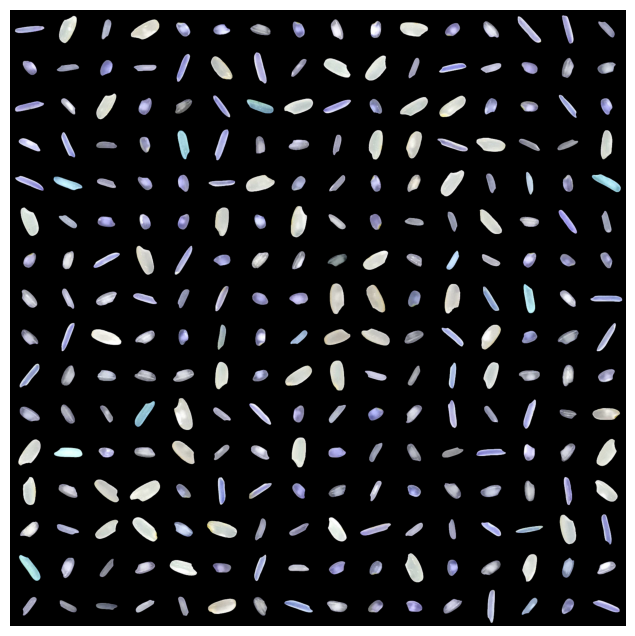

In [ ]:
for item in train_dataset_loader:
    plt.figure(figsize=(16, 8))
    image, _ = item
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

## Criação da Rede Neural

A criação da rede neural foi da seguinte forma:
 - Uso de camadas convolucionais, sendo a primeira composta leando em consideração o valor RGB, por isso no parâmetro `in_channels` temos o valor 3.
 - Uso de Normalização em Batch para acelerar o treinamento
 - Uso da Função de ativação ReLU  

In [ ]:
class CustomizedConvNet(nn.Module):
    def __init__(self,number_of_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,padding=1,kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,padding=1,kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=20)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,padding=1,kernel_size=3)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)


        self.fc1=nn.Linear(32*25*25, number_of_classes)


    def forward(self, Input):

        output=self.conv1(Input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)

        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=self.pool3(output)


        output = torch.flatten(output, 1)
        output = output.view(-1,32*25*25)
        output=self.fc1(output)


        return output

In [ ]:
model = CustomizedConvNet(5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model

CustomizedConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=5, bias=True)
)

In [ ]:
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
    for image, label in valid_dl:
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}

def fit_to_model(train_dl, valid_dl, epochs, optimizer, loss_fn, model):
    history = []
    for epoch in range(epochs):
        for image, label in train_dl:
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        val = validation_step(valid_dl, model, loss_fn)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss,
                        "val_loss": val['val_loss'],
                        "val_acc": val['val_acc']
                       })
    return history

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)


In [ ]:
train_dataset_loader= DeviceDataLoader(train_dataset_loader, device)
valid_dataset_loader = DeviceDataLoader(valid_dataset_loader, device)

Após preparar o dado usando a funções a cima, consideramos um otimizador, Adam, para adaptar a taxa de aprendizado a cada época.

In [ ]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 5
history = fit_to_model(train_dataset_loader, valid_dataset_loader, epochs, optimizer, Loss, model)

Epoch [0/5] => loss: 0.024296710267663002, val_loss: 0.04424957185983658, val_acc: 0.984375
Epoch [1/5] => loss: 0.005307046230882406, val_loss: 0.009683639742434025, val_acc: 1.0
Epoch [2/5] => loss: 0.003829853143543005, val_loss: 0.01946069486439228, val_acc: 0.9921875
Epoch [3/5] => loss: 0.003848325926810503, val_loss: 0.023225093260407448, val_acc: 0.9921875
Epoch [4/5] => loss: 0.01683744788169861, val_loss: 0.01727655529975891, val_acc: 0.99609375


## **Conclusão**

Ao fim desse treinamento, notamos que o uso de GPU é imensamente recomendado caso deseje uma saída mais rápida, considerando que rodamos o código no Google Colab notamos que para o treinamento das 5 épocas demorou cerca de 60 minutos, notamos também que mudanças na configuração inicial das imagens, e as transformações que fizemos no início deste notebook foram essenciais para obter uma boa acurácia, em testes preliminares não tinhamos feito o passo de normalizar e o resultado não foi bom. A parte mais complexa do trabalho foi entender como a rede foi montada, usando o exemplo passado em aula e esse que encontramos, percebemos que há um universo a ser explorado na criação e configuração da rede. Durante o curso vimos muitos exemplos de treinamento com dados em forma de dataframes, utilizamos este projeto para explorar e entender as nuances de trabalhar com imagens; Utilizamos o Google Colab para executar aatividade por ser mais fácil de compartilhar e por diminiuir a complexidade de instalação de pacotes e configuração do sistema.

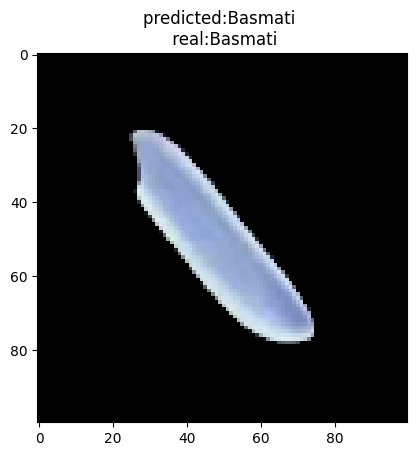

In [ ]:
model = model.cpu()
with torch.no_grad():

    for img,label in test_dataset_loader:
        imgs = img[10]
        labels = label[10]
        output_model = imgs.unsqueeze(0)
        output_model = model(output_model)
        index = output_model.argmax()
        imgs = torch.permute(imgs,(1,2,0))
        plt.imshow(imgs)
        plt.title(f"predicted:{ model_dataset.classes[index]} \n real:{ model_dataset.classes[labels]}")
        break